# Experiment 3

Experiment 3 is about to further explore the impact of the hardness of the negative examples on the model.

* [Reducing Data](#Reducing-Data)
* [Training](#Training)
* [Evaluating](#Evaluating)
* [Plots](#Plots)

In [1]:
import sys
sys.path.append('..')

## Reducing Data

> Aimed to solve the 'OutOfMemoryError' but nothing changed.

In [129]:
import ir_datasets as irds
import pandas as pd

dataset = irds.load('msmarco-passage/train/triples-small')
BM25_docpairs = pd.read_csv(f'../data/new_docpairs.csv', index_col=False, header=None, names=['query_id', 'doc_id_a', 'doc_id_b'])
true_docpairs = pd.read_csv(f'../data/truenegative_docpairs.csv', index_col=False, header=None, names=['query_id', 'doc_id_a', 'doc_id_b'])

docs = pd.DataFrame(dataset.docs_iter()).set_index('doc_id').text.to_dict()
queries = pd.DataFrame(dataset.queries_iter()).set_index('query_id').text.to_dict()

In [158]:
docids = list(set(BM25_docpairs['doc_id_a'].astype(str).tolist() + BM25_docpairs['doc_id_b'].astype(str).tolist() + true_docpairs['doc_id_b'].astype(str).tolist()))
qids = BM25_docpairs['query_id'].astype(str).tolist()

In [130]:
from tqdm.notebook import tqdm
import numpy as np

reduced_docs = {}

for docid in tqdm(docids):
    reduced_docs[docid] = docs[docid]

  0%|          | 0/265041 [00:00<?, ?it/s]

In [159]:
reduced_queries = {}

for qid in tqdm(qids):
    reduced_queries[qid] = queries[qid]

  0%|          | 0/100000 [00:00<?, ?it/s]

In [161]:
from utils import save_data

save_data(reduced_docs, 'data', 'reduced_docs')
save_data(reduced_queries, 'data', 'reduced_queries')

## Training

In [1]:
%run -i '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3' --batch_size 16 --mode 'BM25-Warm-Up' --fraction 0.25

/home/jht412/anaconda3/envs/py310_20230225/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


  0%|          | 0/100000.0 [00:00<?, ?it/s]

In [6]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3' --mode 'BM25-Warm-Up' --fraction 0.25

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                        | 32/100000.0 [00:03<2:44:56, 10.10it/s, loss=1.11]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|███████████████████▉| 99968/100000.0 [15:52<00:00, 104.99it/s, loss=0.0127]
100%|███████████████████▉| 99968/100000.0 [15:51<00:00, 105.06it/s, loss=0.0127]


In [5]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3' --mode 'BM25-Warm-Up' --fraction 0.75

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                         | 32/100000.0 [00:03<2:46:54,  9.98it/s, loss=1.1]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|███████████████████| 100000/100000.0 [15:45<00:00, 105.76it/s, loss=0.0167]
100%|███████████████████| 100000/100000.0 [15:45<00:00, 105.76it/s, loss=0.0167]


### Limiting the max length to 128 with batch size 64

In [1]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.25 --train_steps 1.2e6 --batch_size 64 --size 'full' --limit 128

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                   | 128/1200000.0 [00:49<129:42:56,  2.57it/s, loss=0.226]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|███████████████| 1200000/1200000.0 [2:08:41<00:00, 155.41it/s, loss=0.0022]
100%|███████████████| 1200000/1200000.0 [2:08:41<00:00, 155.41it/s, loss=0.0022]


In [2]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.5 --train_steps 1.2e6 --batch_size 64 --size 'full' --limit 128

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                   | 128/1200000.0 [00:48<125:10:40,  2.66it/s, loss=0.228]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|██████████████| 1200000/1200000.0 [2:08:37<00:00, 155.48it/s, loss=0.00268]
100%|██████████████| 1200000/1200000.0 [2:08:37<00:00, 155.49it/s, loss=0.00268]


In [3]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.75 --train_steps 1.2e6 --batch_size 64 --size 'full' --limit 128

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                   | 128/1200000.0 [00:48<126:00:50,  2.64it/s, loss=0.222]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|██████████████| 1200000/1200000.0 [2:08:17<00:00, 155.90it/s, loss=0.00309]
100%|██████████████| 1200000/1200000.0 [2:08:17<00:00, 155.90it/s, loss=0.00309]


In [4]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 1 --train_steps 1.2e6 --batch_size 64 --size 'full' --limit 128

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                   | 128/1200000.0 [00:49<128:22:25,  2.60it/s, loss=0.224]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|██████████████| 1200000/1200000.0 [2:08:07<00:00, 156.09it/s, loss=0.00323]
100%|██████████████| 1200000/1200000.0 [2:08:08<00:00, 156.09it/s, loss=0.00323]


### Limiting the max length to 128 with batch size 16

In [5]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.25 --train_steps 1.2e6 --batch_size 16 --size 'full' --limit 128

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                    | 32/1200000.0 [00:48<507:29:19,  1.52s/it, loss=0.936]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|████████████████| 1200000/1200000.0 [3:23:53<00:00, 98.09it/s, loss=0.0104]
100%|████████████████| 1200000/1200000.0 [3:23:53<00:00, 98.09it/s, loss=0.0104]


In [6]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.5 --train_steps 1.2e6 --batch_size 16 --size 'full' --limit 128

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                     | 32/1200000.0 [00:49<512:09:58,  1.54s/it, loss=0.97]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|████████████████| 1200000/1200000.0 [3:24:34<00:00, 97.77it/s, loss=0.0121]
100%|████████████████| 1200000/1200000.0 [3:24:34<00:00, 97.76it/s, loss=0.0121]


In [7]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.75 --train_steps 1.2e6 --batch_size 16 --size 'full' --limit 128

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                    | 32/1200000.0 [00:49<510:33:12,  1.53s/it, loss=0.974]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|████████████████| 1200000/1200000.0 [3:23:57<00:00, 98.06it/s, loss=0.0139]
100%|████████████████| 1200000/1200000.0 [3:23:57<00:00, 98.06it/s, loss=0.0139]


In [8]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 1 --train_steps 1.2e6 --batch_size 16 --size 'full' --limit 128

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                    | 32/1200000.0 [00:48<509:17:20,  1.53s/it, loss=0.892]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|████████████████| 1200000/1200000.0 [3:24:24<00:00, 97.84it/s, loss=0.0169]it/s, loss=0.0163]
100%|████████████████| 1200000/1200000.0 [3:24:25<00:00, 97.84it/s, loss=0.0169]


### Batch size 8 without limiting the length

In [9]:
# 20230731 batch size 8 - 1.2 million data

!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.25 --train_steps 1.2e6 --batch_size 8 --size 'full'

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                    | 16/1200000.0 [00:49<1023:32:12,  3.07s/it, loss=2.02]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|████████████████| 1200000/1200000.0 [5:47:10<00:00, 57.61it/s, loss=0.0311]5.43it/s, loss=0.0313]136320/1200000.0 [5:28:48<17:34, 60.39it/s, loss=0.031]
100%|████████████████| 1200000/1200000.0 [5:47:10<00:00, 57.61it/s, loss=0.0311]


In [10]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.5  --train_steps 1.2e6 --batch_size 8 --size 'full'

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                    | 16/1200000.0 [00:48<1016:46:39,  3.05s/it, loss=2.07]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|████████████████| 1200000/1200000.0 [5:51:11<00:00, 56.95it/s, loss=0.0431]
100%|████████████████| 1200000/1200000.0 [5:51:11<00:00, 56.95it/s, loss=0.0431]


In [11]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 0.75 --train_steps 1.2e6 --batch_size 8 --size 'full'

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                    | 16/1200000.0 [00:49<1023:43:12,  3.07s/it, loss=2.06]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|████████████████| 1200000/1200000.0 [5:47:52<00:00, 57.49it/s, loss=0.0384]
100%|████████████████| 1200000/1200000.0 [5:47:51<00:00, 57.49it/s, loss=0.0384]


In [12]:
!accelerate launch '../train.py' --dataset_name 'msmarco-passage/train/triples-small' --out_dir 'model_exp3_full' --mode 'BM25-Warm-Up' --fraction 1 --train_steps 1.2e6 --batch_size 8 --size 'full'

INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 1
INFO:torch.distributed.distributed_c10d:Added key: store_based_barrier_key:1 to store for rank: 0
INFO:torch.distributed.distributed_c10d:Rank 0: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
INFO:torch.distributed.distributed_c10d:Rank 1: Completed store-based barrier for key:store_based_barrier_key:1 with 2 nodes.
  0%|                    | 16/1200000.0 [00:48<1015:52:36,  3.05s/it, loss=2.11]INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
INFO:torch.nn.parallel.distributed:Reducer buckets have been rebuilt in this iteration.
100%|████████████████| 1200000/1200000.0 [5:48:46<00:00, 57.34it/s, loss=0.0391]
100%|████████████████| 1200000/1200000.0 [5:48:46<00:00, 57.34it/s, loss=0.0391]


## Evaluating

In [ ]:
# Exp 1 with Exp 2 (0.5) and Exp 3 (0.25, 0.75)

%run -i '../evaluate.py' --output_name '20230727' --batch_size 16 --exp 'exp3'

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


17:11:25.271 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.
17:11:26.764 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.


In [5]:
%run -i '../evaluate.py' --output_name '20230804_limit128' --batch_size 64 --exp 'exp3_full' --limit 128

PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


19:34:21.079 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.
19:34:22.646 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.


monoT5: 100%|██████████████████████████| 3020/3020 [10:11<00:00,  4.93batches/s]


In [6]:
%run -i '../evaluate.py' --output_name '20230804_limit128' --batch_size 16 --exp 'exp3_full' --limit 128

20:26:10.926 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.
20:26:12.370 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.


monoT5: 100%|████████████████████████| 12078/12078 [09:16<00:00, 21.71batches/s]


In [17]:
%run -i '../evaluate.py' --output_name '20230804' --batch_size 8 --exp 'exp3_full'

17:10:48.093 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.
17:10:49.501 [main] WARN org.terrier.structures.BaseCompressingMetaIndex - Structure meta reading data file directly from disk (SLOW) - try index.meta.data-source=fileinmem in the index properties file. 1.9 GiB of memory would be required.


monoT5: 100%|████████████████████████| 24156/24156 [09:48<00:00, 41.07batches/s]


### Plots

Plots for full size data models with input length limit of 128 and batch size of 64

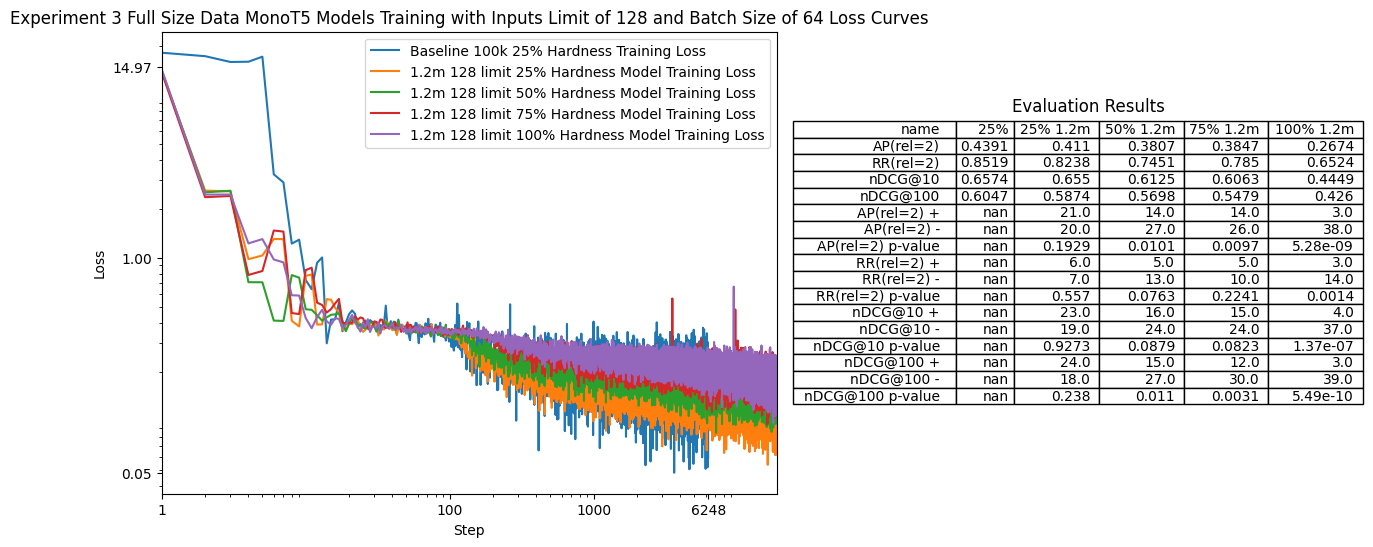

In [8]:
from utils import get_curves
import pandas as pd

result_df = pd.read_csv(f'results/test-2019_20230804_limit128_64.csv', index_col=0)
logs_paths = [
    'model_exp3/model_16_0.25',
    'model_exp3_full/model_64_0.25_limit_128',
    'model_exp3_full/model_64_0.5_limit_128',
    'model_exp3_full/model_64_0.75_limit_128',
    'model_exp3_full/model_64_1_limit_128'
]
labels = [
    'Baseline 100k 25% Hardness Training Loss',
    '1.2m 128 limit 25% Hardness Model Training Loss',
    '1.2m 128 limit 50% Hardness Model Training Loss',
    '1.2m 128 limit 75% Hardness Model Training Loss',
    '1.2m 128 limit 100% Hardness Model Training Loss'
]
get_curves(logs_paths, result_df, 'Experiment 3 Full Size Data MonoT5 Models Training with Inputs Limit of 128 and Batch Size of 64', labels)

Plots for full size data models with input length limit of 128 and batch size of 16

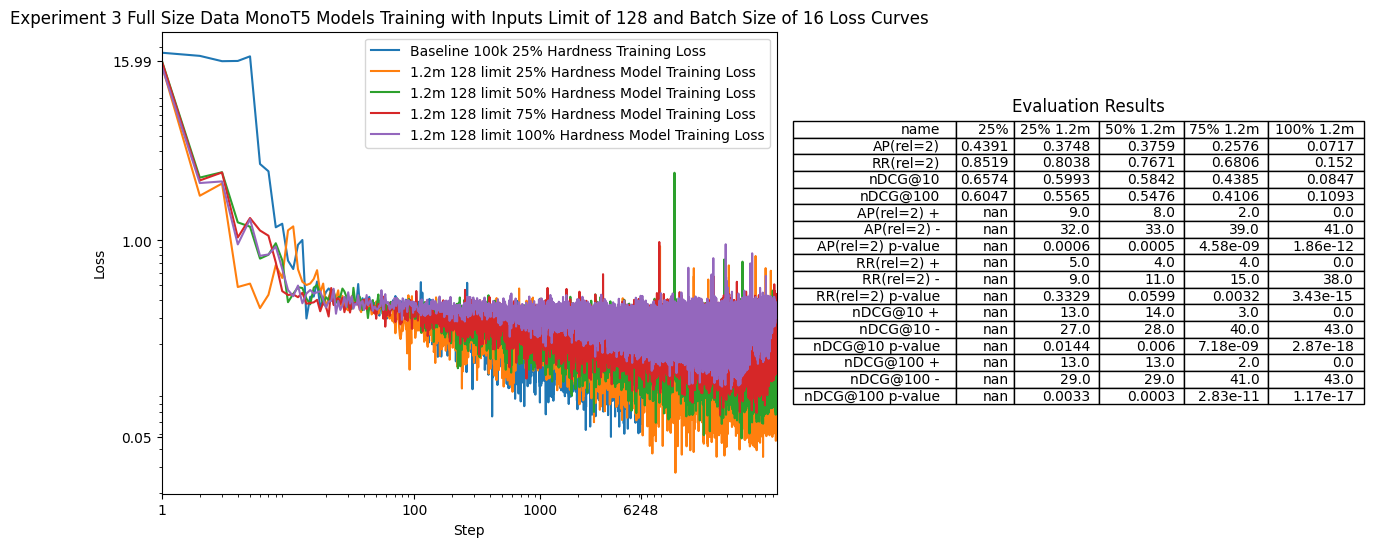

In [2]:
from utils import get_curves
import pandas as pd

result_df = pd.read_csv(f'results/test-2019_20230804_limit128_16.csv', index_col=0)
logs_paths = [
    'model_exp3/model_16_0.25',
    'model_exp3_full/model_16_0.25_limit_128',
    'model_exp3_full/model_16_0.5_limit_128',
    'model_exp3_full/model_16_0.75_limit_128',
    'model_exp3_full/model_16_1_limit_128'
]
labels = [
    'Baseline 100k 25% Hardness Training Loss',
    '1.2m 128 limit 25% Hardness Model Training Loss',
    '1.2m 128 limit 50% Hardness Model Training Loss',
    '1.2m 128 limit 75% Hardness Model Training Loss',
    '1.2m 128 limit 100% Hardness Model Training Loss'
]
get_curves(logs_paths, result_df, 'Experiment 3 Full Size Data MonoT5 Models Training with Inputs Limit of 128 and Batch Size of 16', labels)

Plots for full size data models with batch size of 8 (Failed)

In [24]:
from utils import get_curves

result_df = pd.read_csv(f'results/test-2019_20230804_8-Copy.csv', index_col=0)
logs_paths = [
    'model_exp3/model_16_0.25',
    'model_exp3_full/model_8_0.25',
    'model_exp3_full/model_8_0.5',
    'model_exp3_full/model_8_0.75',
    'model_exp3_full/model_8_1'
]
labels = [
    'Baseline 100k 25% Hardness Training Loss',
    '1.2m 25% Hardness Model Training Loss',
    '1.2m 50% Hardness Model Training Loss',
    '1.2m 75% Hardness Model Training Loss',
    '1.2m 100% Hardness Model Training Loss'
]
get_curves(logs_paths, result_df, 'Experiment 3 Full Size Data MonoT5 Models Training with Batch Size of 8', labels)

JSONDecodeError: Extra data: line 1 column 3082851 (char 3082850)